# Preliminary SARIMA Model
Building a SARIMA Model from County 0JTMM, 2022

References: 
- https://github.com/egorhowell/Youtube/blob/main/Time-Series-Crash-Course/18.%20SARIMA.ipynb
- https://github.com/TheErdosInstitute/data-science-fall-2024/blob/main/07_time_series_II/lecture_7/3_SARIMA.ipynb

### Why SARIMA
- flexible model that can be tuned to suit various different time series datasets. In our case, we likely want to predict based on data from a certain county, so all of the parameters will depend on PACF/ACF patterns per each county
- based on EDA, there seems to be seasonal component to the data, which can be captured by SARIMA

### Modeling strategy (idea, based on problem session 7)
- each model should be fit to data for a single county (or a type of county if appropriate, e.g. rural)
- ideally, get multiple years worth of data for that county and store the number of calls each day as our timeseries data
- investigate PACF and ACF graphs to identify reasonable parameters (p,d,q)(P,D,Q)m
- fit SARIMA model on training data (decide how large hold out set should be)
- compare MSE of our custom model to baseline model (naive forecast?) and the auto ARIMA model (goal: find something that outperforms baseline)
- use best model to predict future call volume

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from seaborn import set_style
set_style=("whitegrid")

In [114]:
#create dataframe from county 0JTMM, 2022
L=[]
for i in range(0,531):
    L.append(pd.read_parquet('data/pub_pcrevents0JTMM.parquet.gzip/part.'+str(i)+'.parquet'))

df=pd.concat(L).reset_index()

#create DateTime column
df['DateTime']=pd.to_datetime(df['eTimes_03'], format='%d%b%Y:%H:%M:%S',exact=False, errors='coerce')

#create DayOfYear column (lists day of year as a single number 1-365)
df['DayOfYear']=df.DateTime.dt.dayofyear

In [115]:
#create data: stores the number of calls each day
data=df.DayOfYear.value_counts().sort_index().reset_index().rename(columns={'index':'Value','DayOfYear':'day_of_yr'})
data

,day_of_yr,count
0,1,91
1,2,86
2,3,84
3,4,90
4,5,86
...,...,...
360,361,97
361,362,92
362,363,109
363,364,113


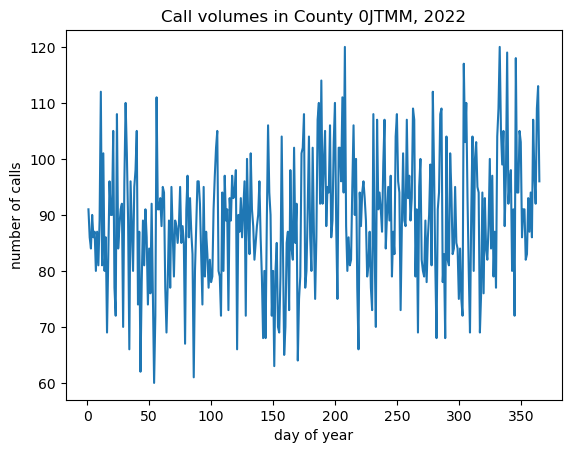

In [116]:
#Plot of the number of calls each day
plt.plot(data['day_of_yr'], data['count'])
plt.title('Call volumes in County 0JTMM, 2022')
plt.xlabel('day of year')
plt.ylabel('number of calls')
plt.show()

The data looks like it has a slight upwards trend, and we need to make it stationary (constant mean and variance over time) in order to apply the ARIMA model.

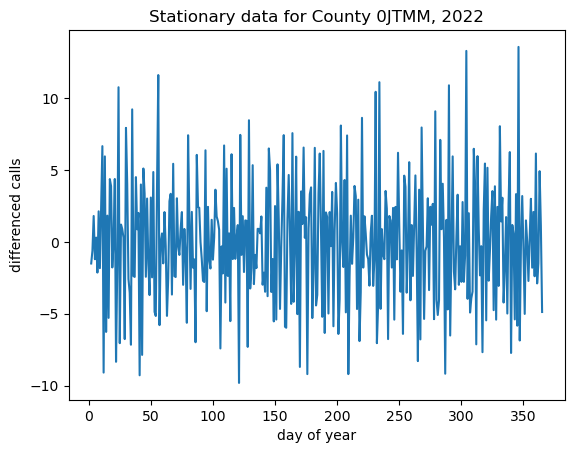

In [117]:
from scipy.stats import boxcox

#make data stationary
data['calls_box_cox'], lam =boxcox(data['count']) #boxcox returns a tuple: transformed data set, lambda that maximizes log-likelihood
data['calls_diff']=data['calls_box_cox'].diff()
data.dropna(inplace=True)

#plot stationary data
plt.plot(data['day_of_yr'], data['calls_diff'])
plt.title('Stationary data for County 0JTMM, 2022')
plt.xlabel('day of year')
plt.ylabel('differenced calls')
plt.show()

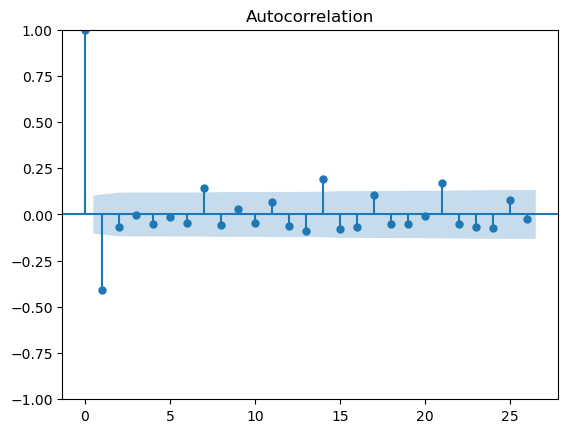

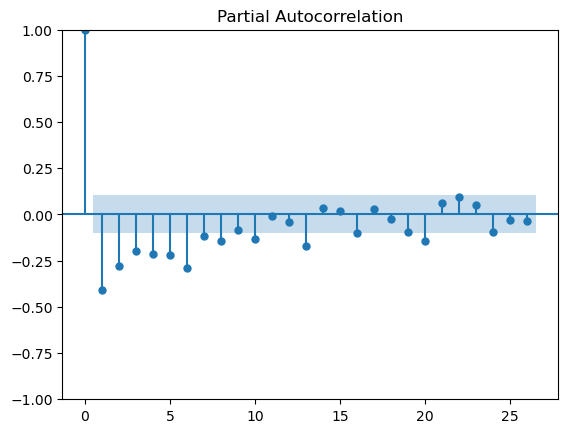

In [153]:
#Modelling
#(partial) autocorrelation plots
# autocorrelation: correlation between x_n and x_{n-i}
# partial ac: correlation between the linear combination of x_{n,n-1,...n-i+1} and x_{n-i}
# useful in finding parameters p and q
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(data['calls_diff'])
plot_pacf(data['calls_diff'], method='ywm')
#ax1.tick_params(axis='both', labelsize=12)
#ax2.tick_params(axis='both', labelsize=12)
plt.show()

### Determining parameters
We probably want to use data from several years in order to see yearly seasonality. (I don't know where to find previous years for this county.)

For now, I will use **auto_arima** from pmdarima

In [119]:
from pmdarima import auto_arima

auto_arima(data.calls_diff, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2115.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2051.358, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1934.321, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2113.217, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1932.885, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1927.667, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2049.361, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1929.271, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1927.417, Time=0.04 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1929.417, Time=0

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

This model gives a flatlining prediction, so I tried out different hyperparameters by hand.

In [149]:
import statsmodels.tsa.api as sm
from scipy.special import inv_boxcox

#train test split
train=data.iloc[:-int(len(data)*0.1)]
test=data.iloc[-int(len(data)*0.1):]

#ARIMA model
model=sm.ARIMA(train.calls_box_cox, order=(1,1,1), seasonal_order=(1,1,1,14)).fit() #messing with the parameters changes the model
boxcox_forecasts=model.forecast(len(test))
forecasts=inv_boxcox(boxcox_forecasts, lam) #undo the boxcox transform we did earlier

c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Karina\anaconda3\envs\erdos_fall_2024\Lib\site-pack

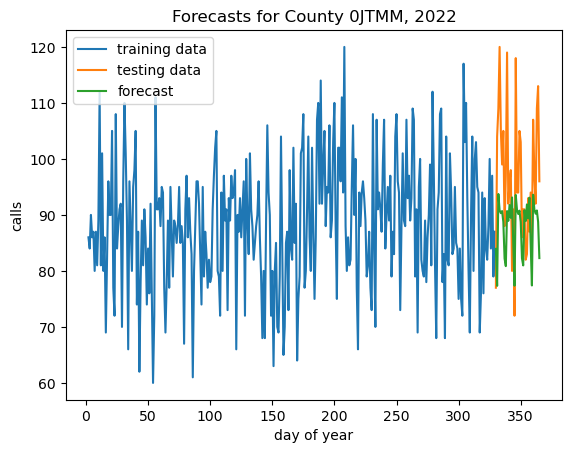

In [150]:
#plot forecasts

plt.plot(train['day_of_yr'], train['count'], label='training data') #train
plt.plot(test['day_of_yr'], test['count'], label='testing data') #test
plt.plot(test['day_of_yr'], forecasts, label='forecast') #forecast
plt.legend()
plt.title('Forecasts for County 0JTMM, 2022')
plt.xlabel('day of year')
plt.ylabel('calls')
plt.show()


This SARIMA model is based on m=14 seasonality (2 weeks) based on the spike at 14 on the ACF graph.